# Искусственный интеллект
## ЛР 3 (часть 1)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Загрузка датасета
### Pet's Faces Dataset
Используем упрощенный датасет Oxford-IIIT Dataset с вырезанными лицами домашних животных. Для начала загружаем его:

In [2]:
import pathlib

dataset_url = "https://mslearntensorflowlp.blob.core.windows.net/data/petfaces.tar.gz"
data_dir = tf.keras.utils.get_file('petfaces', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

Посмотрим, сколько всего изображений у нас есть

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3211


Посмотрим, как выглядят картинки

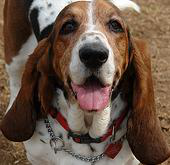

In [4]:
bassets = list(data_dir.glob('dog_basset/*'))
PIL.Image.open(str(bassets[0]))

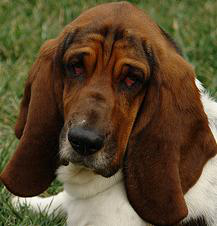

In [5]:
PIL.Image.open(str(bassets[6]))

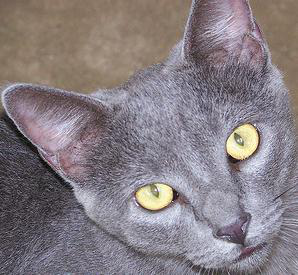

In [6]:
russian_cats = list(data_dir.glob('cat_Russian/*'))
PIL.Image.open(str(russian_cats[0]))

*красивое*

## Создание датасета

In [7]:
batch_size = 32
img_height = 128
img_width = 128

Поделим датасет на трейн и валидацю. На валидацию отдадим 20% картинок

In [8]:
train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=0xDEAD,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3211 files belonging to 35 classes.
Using 2569 files for training.


In [9]:
val = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=0xDEAD,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3211 files belonging to 35 classes.
Using 642 files for validation.


Посмотрим, какие классы у нас есть

In [10]:
class_names = train.class_names
print(class_names)

['cat_Abyssinian', 'cat_Bengal', 'cat_Birman', 'cat_Bombay', 'cat_British', 'cat_Egyptian', 'cat_Maine', 'cat_Persian', 'cat_Ragdoll', 'cat_Russian', 'cat_Siamese', 'cat_Sphynx', 'dog_american', 'dog_basset', 'dog_beagle', 'dog_boxer', 'dog_chihuahua', 'dog_english', 'dog_german', 'dog_great', 'dog_havanese', 'dog_japanese', 'dog_keeshond', 'dog_leonberger', 'dog_miniature', 'dog_newfoundland', 'dog_pomeranian', 'dog_pug', 'dog_saint', 'dog_samoyed', 'dog_scottish', 'dog_shiba', 'dog_staffordshire', 'dog_wheaten', 'dog_yorkshire']


In [51]:
cats_classes = []
dogs_classes = []

for i, class_name in enumerate(class_names):
    if class_name[:3] == 'cat':
        cats_classes.append(i)
    elif class_name[:3] == 'dog':
        dogs_classes.append(i)
    else:
        print('Error')

print('Cats classes:', cats_classes)
print('Dogs classes:', dogs_classes)

Cats classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Dogs classes: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


Закинем датасет в кэш, чтобы быстрее получать изображения оттуда

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

## Обучение моделей

Будем использовать нейронку со следующей архитектурой:  
[Свертка + пулинг] x3 -> Dense x2 -> Softmax

В начале будем делать аугментацию картинок - рандомный флип по горизонтали, рандомный поворот или рандомный зум. После этого нормализуем картинки, приведя все числа в интервал [0; 1].

In [44]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [45]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(num_classes),
    layers.Softmax()
])

Будем смотреть на обычный эккюраси и топ3 эккюраси.

In [46]:
top3_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', top3_acc])

In [47]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                 

Обучаться будем на гпу

In [48]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [49]:
epochs = 50

history = model.fit(
    train,
    validation_data=val,
    epochs=epochs
)

Epoch 1/50
81/81 [==============================] - 2s 17ms/step - loss: 3.3145 - accuracy: 0.0860 - top_3_accuracy: 0.2265 - val_loss: 2.9243 - val_accuracy: 0.2072 - val_top_3_accuracy: 0.3863
Epoch 2/50
81/81 [==============================] - 1s 14ms/step - loss: 2.7310 - accuracy: 0.2227 - top_3_accuracy: 0.4508 - val_loss: 2.5075 - val_accuracy: 0.3069 - val_top_3_accuracy: 0.5623
Epoch 3/50
81/81 [==============================] - 1s 14ms/step - loss: 2.3447 - accuracy: 0.3379 - top_3_accuracy: 0.5862 - val_loss: 2.2688 - val_accuracy: 0.3629 - val_top_3_accuracy: 0.6308
Epoch 4/50
81/81 [==============================] - 1s 14ms/step - loss: 2.0853 - accuracy: 0.4107 - top_3_accuracy: 0.6431 - val_loss: 2.2517 - val_accuracy: 0.3738 - val_top_3_accuracy: 0.6620
Epoch 5/50
81/81 [==============================] - 1s 14ms/step - loss: 1.8858 - accuracy: 0.4589 - top_3_accuracy: 0.7030 - val_loss: 1.9071 - val_accuracy: 0.4517 - val_top_3_accuracy: 0.7165
Epoch 6/50
81/81 [=======

Построим графики для метрик и лосса

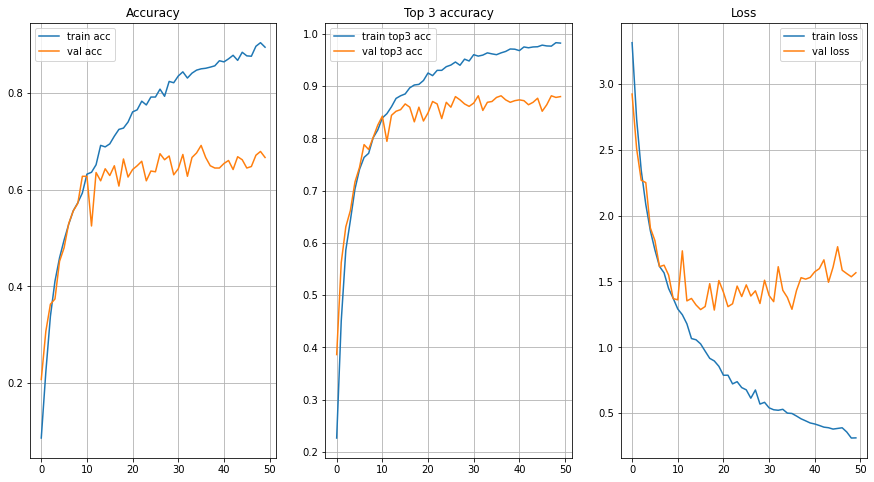

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='train acc')
plt.plot(epochs_range, val_acc, label='val acc')
plt.legend()
plt.grid()
plt.title('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, top3_acc, label='train top3 acc')
plt.plot(epochs_range, val_top3_acc, label='val top3 acc')
plt.legend()
plt.grid()
plt.title('Top 3 accuracy')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='train loss')
plt.plot(epochs_range, val_loss, label='val loss')
plt.legend()
plt.grid()
plt.title('Loss')

plt.show()

Я пробовал много разных конфигураций модели: я менял количество и параметры сверточных слоев, добавлял больше линейных слоев, менял лернинг рейт и количество эпох. По итогу эта модель оказалась наилучшей по метрикам. 

Посчитаем точность бинарной классификации - кошки vs собаки

In [85]:
def count_binary_accuracy(model, val):
    correct = 0
    total = 0

    for x, y in val:
        y_pred = np.argmax(model.predict(x), axis=1)
        correct_cats = sum([y_pred[i] in cats_classes and y[i] in cats_classes for i in range(len(y))])
        correct_dogs = sum([y_pred[i] in dogs_classes and y[i] in dogs_classes for i in range(len(y))])
        correct += correct_cats + correct_dogs
        total += len(y)
    return correct / total

In [89]:
print('Cats vs dogs accuracy =', count_binary_accuracy(model, val))

Cats vs dogs accuracy = 0.9579439252336449


Построим confusion matrix

In [119]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [120]:
def plot_confusion_matrix(model, val):
    y_real = np.array([])
    y_pred = np.array([])

    for x, y in val:
        y_real = np.concatenate((y_real, y), axis=None)
        y_pred = np.concatenate((y_pred, np.argmax(model.predict(x), axis=1)), axis=None)    
    conf_matrix = tf.math.confusion_matrix(y_real, y_pred, num_classes=num_classes)
    
    df_cm = pd.DataFrame(confustion_matrix, index = [i for i in class_names], columns = [i for i in class_names])
    plt.figure(figsize = (15, 15))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.show()

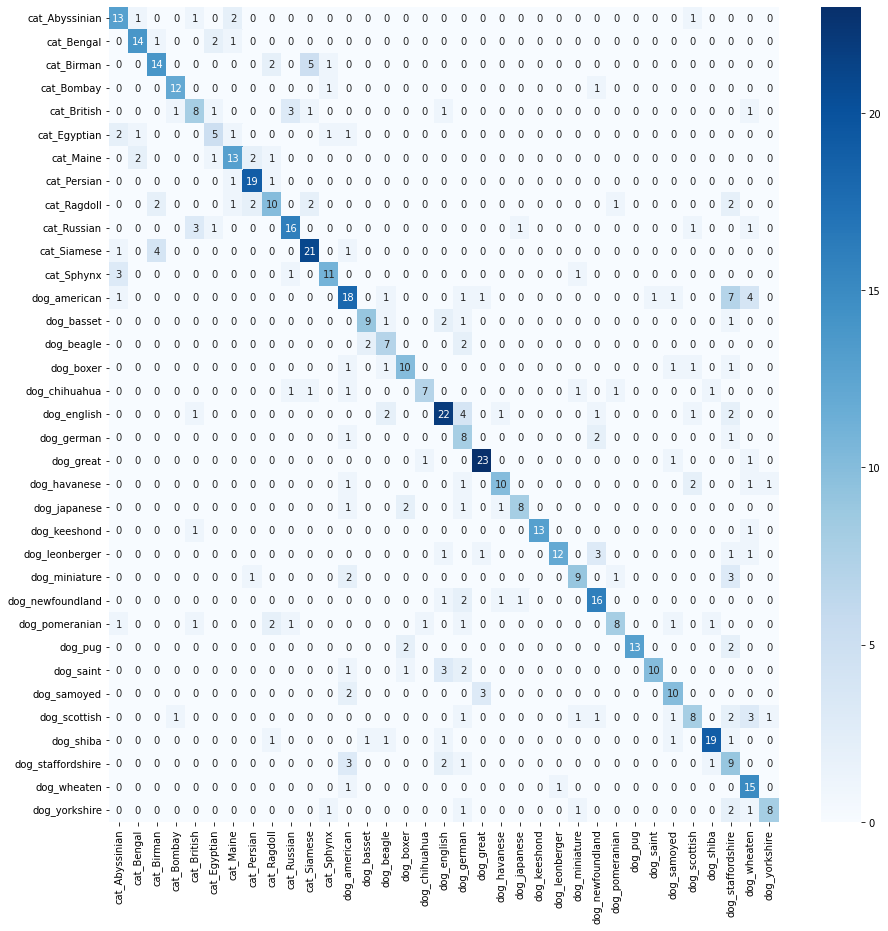

In [121]:
plot_confusion_matrix(model, val)

## Результаты

**Метрики на вале**:  
acc = 0.67  
top3 acc = 0.88
cats vs dogs acc = 0.96

Модель хорошо научилась различать кошек и собак: видим точность бинарной классификации 0.96, а также видим, что левая нижняя и правая верхняя части матрицы неточностей почти нулевые.

Определять непосредственно породы кошек и собак модель может не всегда. Имеем точность 0.67. Однако в 88% случаев правильная порода находится в топ 3 предсказаниях модели.

Сейчас у нас немного фотографий в датасете для каждого класса, поэтому стоит либо расширить датасет, либо попробовать пофайнтюнить нейросетку для получения лучшего результата